# Capstone Project: Classifying clinically actionable genetic mutations

***

## Notebook 2: Pre-processing and EDA

This notebook contains code for pre-processing and additional EDA of the datasets.

<div class="alert alert-block alert-info">
Note: This notebook takes approx. 6 h 30 min to run on a PC with an Intel i7-8565U CPU, 16GB of RAM and Windows 10 operating system.
</div>

### Contents

- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)
- [Text Lemmatisation](#Text-Lemmatisation)
- [EDA on lemmatised text](#EDA-on-lemmatised-text)
    - [Word Cloud for lemmatised text](#Word-Cloud-for-lemmatised-text)
    - [Histogram of 20 most frequent words in Training Dataset](#Histogram-of-20-most-frequent-words-in-Training-Dataset)
- [Creation of dummy columns](#Creation-of-dummy-columns)
- [Deeper examination of correlations between dummy columns](#Deeper-examination-of-correlations-between-dummy-columns)
- [Readiness of Pre-processed Data for Modelling](#Readiness-of-Pre-processed-Data-for-Modelling)
- [Data Export](#Data-Export)

In [1]:
# For tracking the execution time for the entire notebook
import time
import datetime
now = datetime.datetime.now()
print ("Started executing notebook at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
notebook_start = time.time()

Started executing notebook at: 2020-04-15 10:14:04


---

## Importing of Libraries

In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Additional general purpose libraries
from collections import Counter

# For tokenisation, word lemmatisation and other pre-processing
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

# For EDA
from wordcloud import WordCloud

## Data Import

In [3]:
# Import the datasets
train = pd.read_csv("../assets/train_clean.csv", keep_default_na=False)
test = pd.read_csv("../assets/test_clean.csv", keep_default_na=False)

In [4]:
train.shape, test.shape

((3321, 5), (986, 4))

In [5]:
train.head()

,id,text,gene,variation,class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


In [6]:
test.head()

,id,text,gene,variation
0,1,The incidence of breast cancer is increasing i...,CHEK2,H371Y
1,2,An unselected series of 310 colorectal carcino...,AXIN2,Truncating Mutations
2,3,Mycosis fungoides and SÃ©zary syndrome are pri...,WNT4,E216G
3,4,Regulated progression through the cell cycle ...,SUCLA2,G118R
4,5,Pilocytic astrocytoma (PA) is emerging as a tu...,BRAF,T599insTT


## Text Lemmatisation

In [7]:
# We define a function to preprocess the text
def preprocess(input_string):
    text_lower = BeautifulSoup(input_string).get_text().lower()
    return re.sub("[^a-zA-Z]", " ", text_lower) # we lower the case, and remove punctuation

In [8]:
%%time
train['text_preproc'] = [preprocess(i) for i in list(train['text'])]
test['text_preproc'] = [preprocess(i) for i in list(test['text'])]

Wall time: 57.9 s


In [9]:
# We define a function to perform POS (Parts-of-Speech) tagging which should improve the lemmatisation output
def get_wordnet_pos(word):
    # Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # Return wordnet.NOUN if the 'tag' key is not found

In [10]:
def lemmatize(input_string):
    
    # Lemmatise each word of text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input_string)
    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]

    # Remove stopwords
    
    stopwords = nltk.corpus.stopwords.words('english')
    new_stop_words = ['mutation', 'figure', 'fig', 'tumor', 'cell', 'patient', \
                     'use', 'et', 'al', 'also', 'cancer', 'show']
    stopwords.extend(new_stop_words)
    
    stops = set(stopwords)
    
    meaningful_words = [w for w in tokens_lem if not w in stops]
    
    # Join the words back into one string separated by space, and return the result
    return(" ".join(meaningful_words))

In [11]:
# Create a function to track the lemmatisation process as it takes very long
def lemmatize_track(input):
    start = time.time()
    lemm_result = []
    item_max = len(input)
    for item in range(item_max):
        lemm_result.append(lemmatize(input[item]))
        if (item+1)%10 == 0: # print progress after every 10 entries that have been lemmatised
            print ("Finished iteration {} of {}, total time elapsed (h:m:s): {}".format(item+1,
                                                                    item_max+1,
                                                                    datetime.timedelta(seconds=time.time()-start)))
    return lemm_result

In [12]:
%%time
now = datetime.datetime.now()
print ("Started lemmatisation of training text at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
train['lemm_text'] = lemmatize_track(list(train['text_preproc']))

Started lemmatisation of training text at: 2020-04-15 10:15:07
Finished iteration 10 of 3322, total time elapsed (h:m:s): 0:00:46.737938
Finished iteration 20 of 3322, total time elapsed (h:m:s): 0:01:42.117151
Finished iteration 30 of 3322, total time elapsed (h:m:s): 0:02:19.346295
Finished iteration 40 of 3322, total time elapsed (h:m:s): 0:03:03.290246
Finished iteration 50 of 3322, total time elapsed (h:m:s): 0:03:43.676835
Finished iteration 60 of 3322, total time elapsed (h:m:s): 0:04:06.507587
Finished iteration 70 of 3322, total time elapsed (h:m:s): 0:04:47.909868
Finished iteration 80 of 3322, total time elapsed (h:m:s): 0:05:49.744602
Finished iteration 90 of 3322, total time elapsed (h:m:s): 0:06:29.986535
Finished iteration 100 of 3322, total time elapsed (h:m:s): 0:07:10.317981
Finished iteration 110 of 3322, total time elapsed (h:m:s): 0:08:37.771863
Finished iteration 120 of 3322, total time elapsed (h:m:s): 0:10:19.142601
Finished iteration 130 of 3322, total time ela

Finished iteration 1100 of 3322, total time elapsed (h:m:s): 1:33:43.999292
Finished iteration 1110 of 3322, total time elapsed (h:m:s): 1:34:20.046055
Finished iteration 1120 of 3322, total time elapsed (h:m:s): 1:35:15.197830
Finished iteration 1130 of 3322, total time elapsed (h:m:s): 1:36:13.513200
Finished iteration 1140 of 3322, total time elapsed (h:m:s): 1:37:29.188890
Finished iteration 1150 of 3322, total time elapsed (h:m:s): 1:38:09.256397
Finished iteration 1160 of 3322, total time elapsed (h:m:s): 1:39:12.385692
Finished iteration 1170 of 3322, total time elapsed (h:m:s): 1:39:58.558573
Finished iteration 1180 of 3322, total time elapsed (h:m:s): 1:40:35.254484
Finished iteration 1190 of 3322, total time elapsed (h:m:s): 1:41:24.652182
Finished iteration 1200 of 3322, total time elapsed (h:m:s): 1:42:48.623370
Finished iteration 1210 of 3322, total time elapsed (h:m:s): 1:43:23.429422
Finished iteration 1220 of 3322, total time elapsed (h:m:s): 1:43:58.082336
Finished ite

Finished iteration 2180 of 3322, total time elapsed (h:m:s): 3:08:42.753346
Finished iteration 2190 of 3322, total time elapsed (h:m:s): 3:09:22.137640
Finished iteration 2200 of 3322, total time elapsed (h:m:s): 3:10:02.608786
Finished iteration 2210 of 3322, total time elapsed (h:m:s): 3:10:47.649812
Finished iteration 2220 of 3322, total time elapsed (h:m:s): 3:11:26.058567
Finished iteration 2230 of 3322, total time elapsed (h:m:s): 3:12:06.923367
Finished iteration 2240 of 3322, total time elapsed (h:m:s): 3:12:44.893533
Finished iteration 2250 of 3322, total time elapsed (h:m:s): 3:13:23.815253
Finished iteration 2260 of 3322, total time elapsed (h:m:s): 3:13:59.516215
Finished iteration 2270 of 3322, total time elapsed (h:m:s): 3:14:39.340973
Finished iteration 2280 of 3322, total time elapsed (h:m:s): 3:15:20.586367
Finished iteration 2290 of 3322, total time elapsed (h:m:s): 3:16:18.267900
Finished iteration 2300 of 3322, total time elapsed (h:m:s): 3:17:54.486443
Finished ite

Finished iteration 3260 of 3322, total time elapsed (h:m:s): 5:00:32.189640
Finished iteration 3270 of 3322, total time elapsed (h:m:s): 5:01:03.858474
Finished iteration 3280 of 3322, total time elapsed (h:m:s): 5:01:35.403563
Finished iteration 3290 of 3322, total time elapsed (h:m:s): 5:02:06.046446
Finished iteration 3300 of 3322, total time elapsed (h:m:s): 5:02:47.538476
Finished iteration 3310 of 3322, total time elapsed (h:m:s): 5:03:33.387531
Finished iteration 3320 of 3322, total time elapsed (h:m:s): 5:04:22.965935
Wall time: 5h 4min 29s


In [13]:
%%time
now = datetime.datetime.now()
print ("Started lemmatisation of test text at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
test['lemm_text'] = lemmatize_track(list(test['text_preproc']))

Started lemmatisation of test text at: 2020-04-15 15:19:37
Finished iteration 10 of 987, total time elapsed (h:m:s): 0:00:34.006083
Finished iteration 20 of 987, total time elapsed (h:m:s): 0:01:31.728472
Finished iteration 30 of 987, total time elapsed (h:m:s): 0:02:15.912733
Finished iteration 40 of 987, total time elapsed (h:m:s): 0:03:21.639538
Finished iteration 50 of 987, total time elapsed (h:m:s): 0:04:15.680768
Finished iteration 60 of 987, total time elapsed (h:m:s): 0:05:17.504866
Finished iteration 70 of 987, total time elapsed (h:m:s): 0:06:19.082055
Finished iteration 80 of 987, total time elapsed (h:m:s): 0:07:58.390675
Finished iteration 90 of 987, total time elapsed (h:m:s): 0:09:08.397720
Finished iteration 100 of 987, total time elapsed (h:m:s): 0:09:50.336760
Finished iteration 110 of 987, total time elapsed (h:m:s): 0:10:38.566449
Finished iteration 120 of 987, total time elapsed (h:m:s): 0:11:46.035231
Finished iteration 130 of 987, total time elapsed (h:m:s): 0:1

In [14]:
train.head()

,id,text,gene,variation,class,text_preproc,lemm_text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate a var...,cyclin dependent kinase cdks regulate variety ...
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,abstract background non small cell lung cance...,abstract background non small lung nsclc heter...
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,abstract background non small cell lung cance...,abstract background non small lung nsclc heter...
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,recent evidence has demonstrated that acquired...,recent evidence demonstrate acquire uniparenta...
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,oncogenic mutations in the monomeric casitas b...,oncogenic monomeric casitas b lineage lymphoma...


In [15]:
test.head()

,id,text,gene,variation,text_preproc,lemm_text
0,1,The incidence of breast cancer is increasing i...,CHEK2,H371Y,the incidence of breast cancer is increasing i...,incidence breast increase china recent decade ...
1,2,An unselected series of 310 colorectal carcino...,AXIN2,Truncating Mutations,an unselected series of colorectal carcino...,unselected series colorectal carcinoma stratif...
2,3,Mycosis fungoides and SÃ©zary syndrome are pri...,WNT4,E216G,mycosis fungoides and s zary syndrome are pri...,mycosis fungoides zary syndrome primary cutane...
3,4,Regulated progression through the cell cycle ...,SUCLA2,G118R,regulated progression through the cell cycle r...,regulate progression cycle require sequential ...
4,5,Pilocytic astrocytoma (PA) is emerging as a tu...,BRAF,T599insTT,pilocytic astrocytoma pa is emerging as a tu...,pilocytic astrocytoma pa emerge entity dysregu...


In [16]:
# Remove the redundant 'text'-related columns
train.drop(columns=['text', 'text_preproc'], inplace=True)
test.drop(columns=['text', 'text_preproc'], inplace=True)

In [17]:
# Rename the lemm_text columns
train.rename(columns={'lemm_text':'text'}, inplace=True)
test.rename(columns={'lemm_text':'text'}, inplace=True)

## EDA on lemmatised text

### Word Cloud for lemmatised text

In [18]:
train.head()

,id,gene,variation,class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small lung nsclc heter...
2,2,CBL,Q249E,2,abstract background non small lung nsclc heter...
3,3,CBL,N454D,3,recent evidence demonstrate acquire uniparenta...
4,4,CBL,L399V,4,oncogenic monomeric casitas b lineage lymphoma...


In [19]:
def word_count(input_string):
    tokenizer = RegexpTokenizer(r'[A-Za-z0-9]{2,}')
    words = tokenizer.tokenize(input_string)
    counter.update(words)

In [20]:
# Create a word frequency dictionary for class 7 variations
counter = Counter()
for input_string in train['text']:
    word_count(input_string)
train_word_freq = dict(counter.most_common())

In [21]:
# Determine size of word frequency dictionary
len(counter)

81294

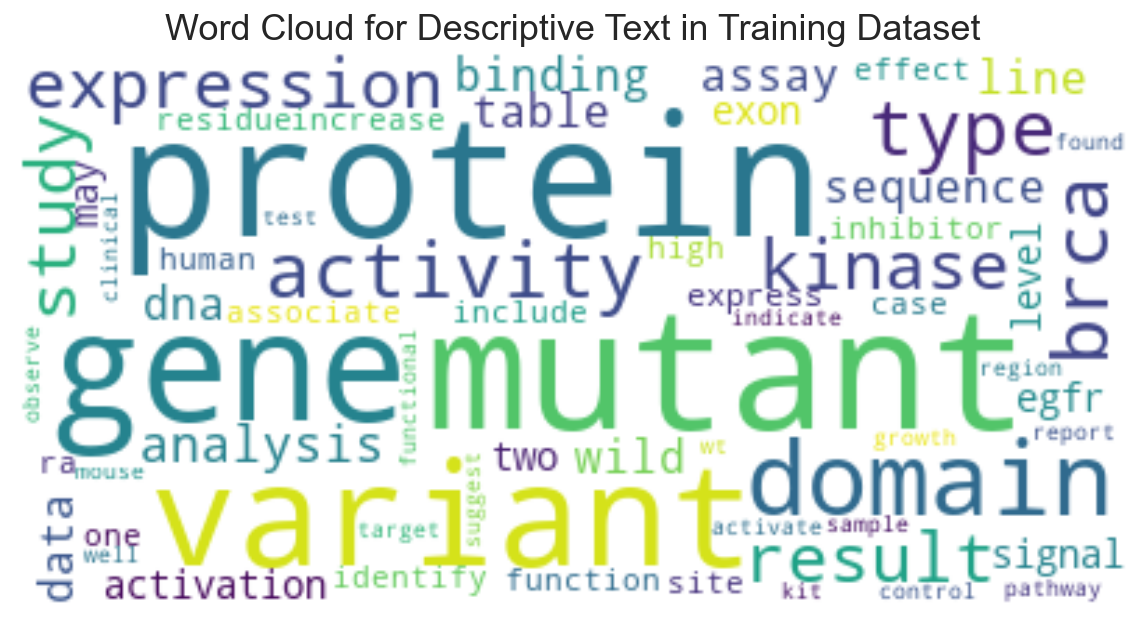

In [51]:
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=60, background_color ='white', min_font_size = 8).generate_from_frequencies(train_word_freq)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Descriptive Text in Training Dataset", fontsize=18)
plt.show()

### Histogram of 20 most frequent words in Training Dataset

In [23]:
labels, values = zip(*train_word_freq.items())
# sort your values in descending order
indSort = np.argsort(values)[::-1]
# rearrange your data
labels = np.array(labels)[indSort][:20]
values = np.array(values)[indSort][:20]
indexes = np.arange(len(labels))

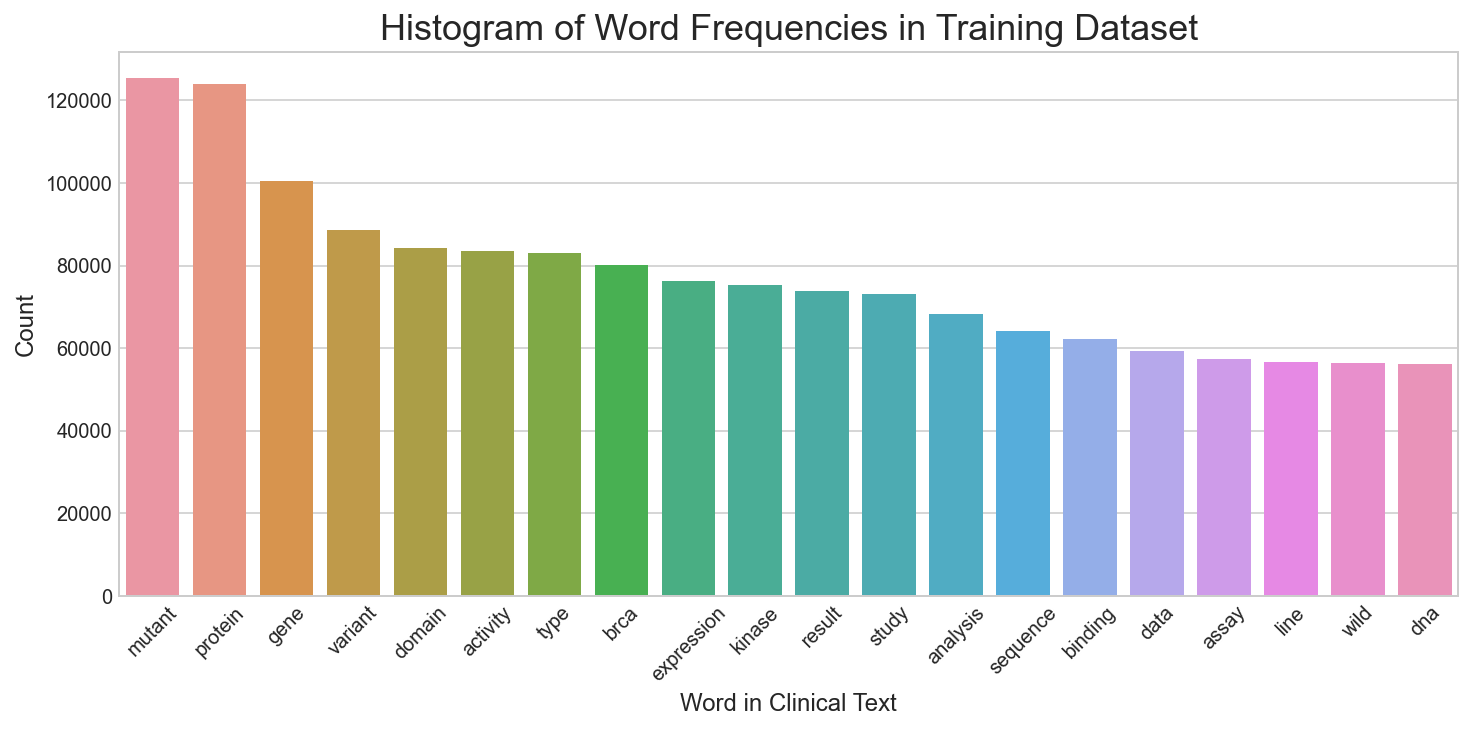

In [52]:
plt.figure(figsize=(12,5))
sns.barplot(indexes, values);
plt.xticks(indexes, labels, rotation=45);
plt.xlabel("Word in Clinical Text", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of Word Frequencies in Training Dataset", fontsize=18);

## Creation of dummy columns

In [25]:
train.head()

,id,gene,variation,class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small lung nsclc heter...
2,2,CBL,Q249E,2,abstract background non small lung nsclc heter...
3,3,CBL,N454D,3,recent evidence demonstrate acquire uniparenta...
4,4,CBL,L399V,4,oncogenic monomeric casitas b lineage lymphoma...


In [26]:
test.head()

,id,gene,variation,text
0,1,CHEK2,H371Y,incidence breast increase china recent decade ...
1,2,AXIN2,Truncating Mutations,unselected series colorectal carcinoma stratif...
2,3,WNT4,E216G,mycosis fungoides zary syndrome primary cutane...
3,4,SUCLA2,G118R,regulate progression cycle require sequential ...
4,5,BRAF,T599insTT,pilocytic astrocytoma pa emerge entity dysregu...


In [27]:
train.shape, test.shape

((3321, 5), (986, 4))

To ensure we get consistent dummy columns created across the train and test datasets, we combine them first, perform get_dummies, then split them apart.

In [28]:
# Create a temporary column called 'dataset' to help us distinguish whether
# each data point is belonging to the training or testing dataset
train['dataset'] = 'train'
test['dataset'] = 'test'

In [29]:
# Create temporary dataframe 'combined' that is a concatenation of the train and test dataframes
combined= pd.concat([train, test], axis=0)

In [30]:
combined.head()

,id,gene,variation,class,text,dataset
0,0,FAM58A,Truncating Mutations,1.0,cyclin dependent kinase cdks regulate variety ...,train
1,1,CBL,W802*,2.0,abstract background non small lung nsclc heter...,train
2,2,CBL,Q249E,2.0,abstract background non small lung nsclc heter...,train
3,3,CBL,N454D,3.0,recent evidence demonstrate acquire uniparenta...,train
4,4,CBL,L399V,4.0,oncogenic monomeric casitas b lineage lymphoma...,train


In [31]:
combined.shape

(4307, 6)

In [32]:
# Create the dummy columns - we set drop_first=False given that we can't be sure we have all
# possible values of 'gene' and 'variation' in our combined dataframe
combined = pd.get_dummies(combined, columns=['gene', 'variation'], drop_first=False)

In [33]:
# Split the combined dataset back to the training and testing datasets based on the 'dataset' column
train_prep = combined[combined['dataset']=='train'].copy()
train_prep.reset_index(inplace=True, drop=True)
train_prep.drop(['dataset'], axis=1, inplace=True)

test_prep = combined[combined['dataset']=='test'].copy()
test_prep.reset_index(inplace=True, drop=True)
test_prep.drop(['dataset', 'class'], axis=1, inplace=True)

In [34]:
train_prep['class'] = train_prep['class'].astype(int)

In [35]:
train_prep.head(3)

,id,class,text,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,...,variation_YAP1-TFE3 Fusion,variation_YWHAE-ROS1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_null1313Y,variation_null189Y,variation_null262Q,variation_null267R,variation_null399R,variation_p61BRAF
0,0,1,cyclin dependent kinase cdks regulate variety ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,abstract background non small lung nsclc heter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,abstract background non small lung nsclc heter...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
test_prep.head(3)

,id,text,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,gene_AGXT,...,variation_YAP1-TFE3 Fusion,variation_YWHAE-ROS1 Fusion,variation_ZC3H7B-BCOR Fusion,variation_ZNF198-FGFR1 Fusion,variation_null1313Y,variation_null189Y,variation_null262Q,variation_null267R,variation_null399R,variation_p61BRAF
0,1,incidence breast increase china recent decade ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,unselected series colorectal carcinoma stratif...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,mycosis fungoides zary syndrome primary cutane...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Deeper examination of correlations between dummy columns

In [37]:
cols = [col for col in train_prep.columns if col not in ['id', 'text']]

In [38]:
%%time
cor_target = abs(train_prep[cols].corr()["class"])

Wall time: 3min 1s


We now take a closer look at the set of ~30 features that are most correlated with the variation 'class'.

In [39]:
relevant_features = cor_target[cor_target>0.04].sort_values(ascending=False)
relevant_features[:10]

class                             1.000000
variation_Truncating Mutations    0.236316
gene_TP53                         0.180837
variation_Deletion                0.173203
gene_SF3B1                        0.137734
gene_ERCC2                        0.101911
variation_Fusions                 0.099008
gene_KRAS                         0.092255
gene_TSC2                         0.091834
gene_CTNNB1                       0.091795
Name: class, dtype: float64

We observe that there are no features that are strongly correlated with 'class'. We proceed to use a heatmap to see if there are any strong correlations amongst these ~30 features.

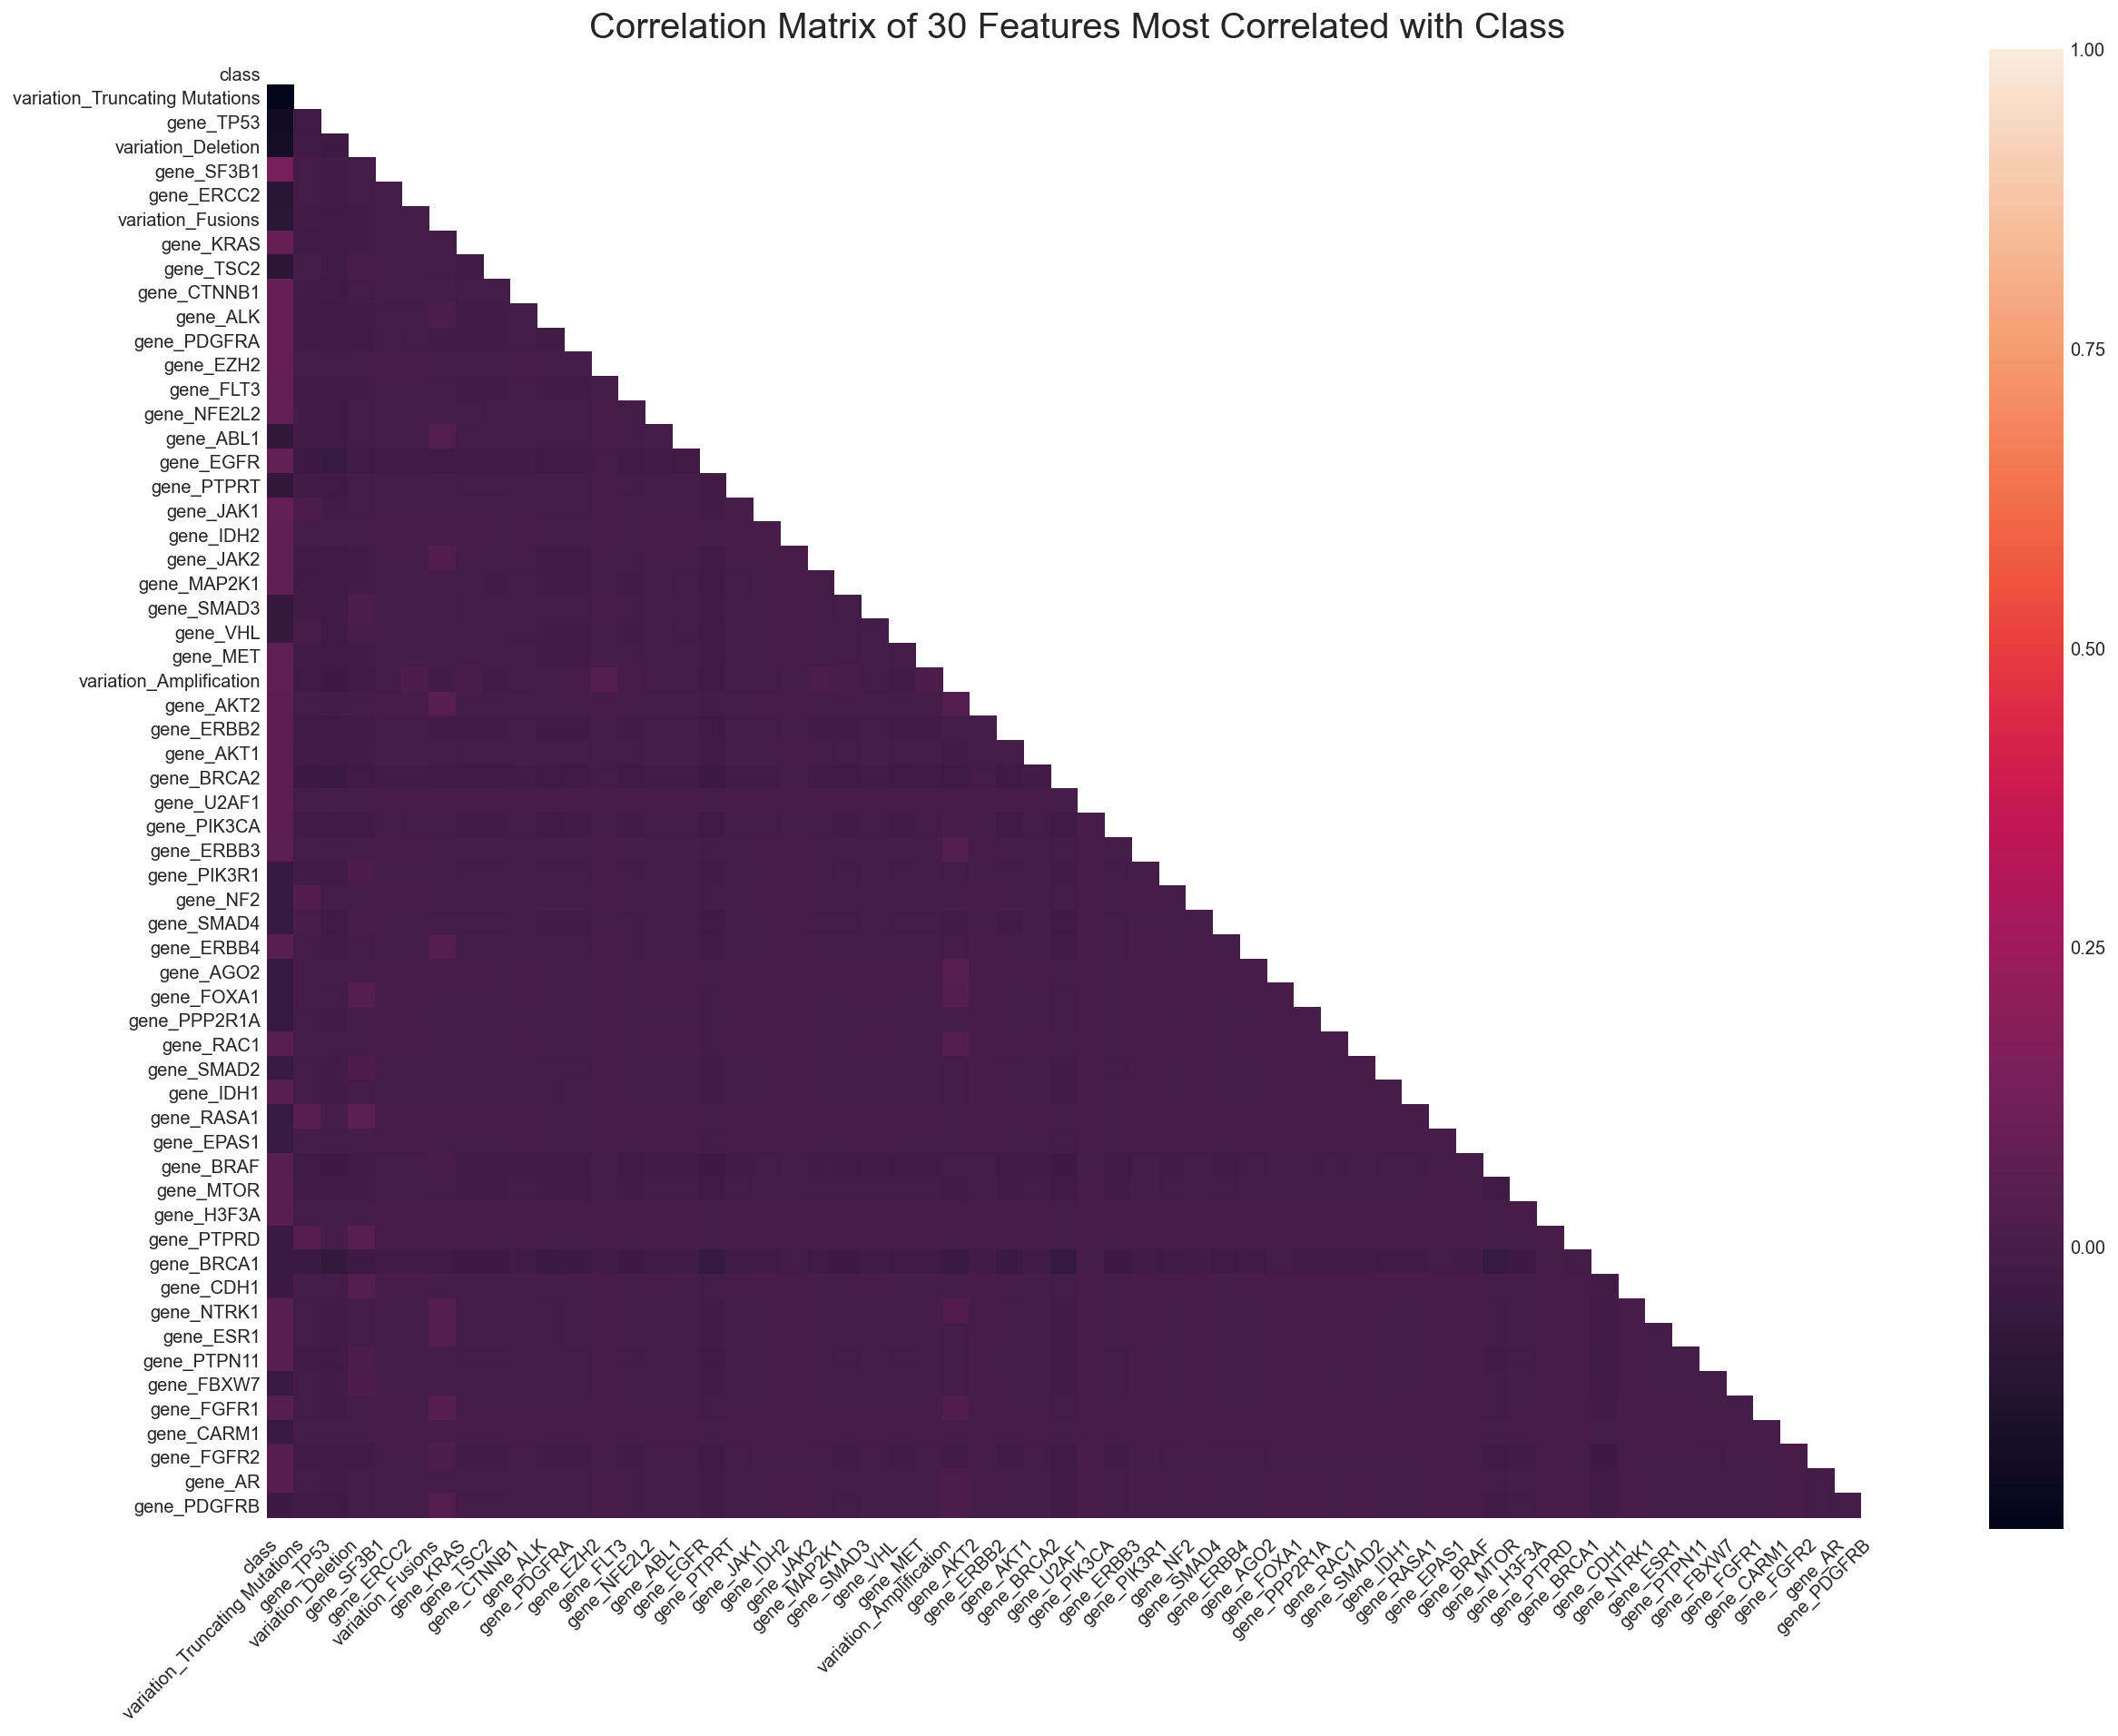

In [50]:
# Plot a scatterplot
fig, ax = plt.subplots(figsize=(20,15))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train_prep[relevant_features.index].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(round(train_prep[relevant_features.index].corr(),3), annot=False, mask=mask, ax=ax)
bottom,top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title("Correlation Matrix of 30 Features Most Correlated with Class", fontsize=20)
plt.show();

As shown above, there are no strong correlations amongst any of the 30 or so features that are most correlated with the variation 'class'. We are therefore unable to perform any feature engineering to combine features (e.g. create interaction features) or justify the removal of any specific features.

We further observe that there is generally stronger correlation between the genes and the variation 'class' rather than between the variations and the variation 'class'.

## Readiness of Pre-processed Data for Modelling

In [41]:
train_prep.shape, test_prep.shape

((3321, 4325), (986, 4324))

- Both the training and testing datasets have undergone cleaning, lemmatisation and creation of dummy columns for the 'gene' and 'variation' features.
- We deem the volume and quality of the training and testing datasets to be sufficient for subsequent modelling.
- However, we note that we have training and testing datasets where the number of features outweigh the number of samples -- this means that our models are likely to be overfitted.

## Data Export

In [42]:
train_prep.to_csv("../assets/train_prep.csv", index=False)
test_prep.to_csv("../assets/test_prep.csv", index=False)

---

In [43]:
# For tracking the execution time for the entire notebook
print ("Notebook execution duration (h:m:s): {}".format(str(datetime.timedelta(seconds=time.time()-notebook_start))))

Notebook execution duration (h:m:s): 6:27:13.764732
